# CIFAR-10 Classification using Convolutional Neural Networks

In [1]:
# to check whether the kernel started in the virtual environment

import sys
print(sys.executable)

!jupyter kernelspec list

/home/yq/miniconda3/envs/tf/bin/python
Available kernels:
  python3    /home/yq/miniconda3/envs/tf/share/jupyter/kernels/python3


## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

https://www.cs.toronto.edu/~kriz/cifar.html

![cifar10.PNG](slides/cifar10.PNG)

## What is Convolution Neural Network? (recap)

### Convolution
![conv.PNG](slides/conv.PNG)
_Image source: https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html_

### Pooling
![pooling.png](slides/pooling.png)
_Image source: https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html_

### Flatten
![flatten.PNG](slides/flatten.PNG)
_Image source: https://www.codeproject.com/Articles/1232042/Introduction-to-Convolutional-Neural-Networks_

### Fully-Connected
![dense.jpg](slides/dense.jpg)
_Image source: https://medium.com/pankajmathur/a-simple-multilayer-perceptron-with-tensorflow-3effe7bf3466_

### LeNet
![lenet.PNG](slides/lenet.PNG)
_Image source: https://www.deeplearning.ai_

Let's start building our network!

In [2]:
# let's import the required libraries for building our CNN!

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

Using TensorFlow backend.


In [3]:
class ConvNet:
    @staticmethod    
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
     
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
     
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
     
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization(axis=-1))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))
     
        return model  

### Dropout
![dropout.png](slides/dropout.png)
_Image source: https://www.deeplearning.ai_

### Softmax
![softmax_eqn.PNG](slides/softmax_eqn.PNG)
![softmax.PNG](slides/softmax.PNG)
_Image source: https://towardsdatascience.com/deep-learning-concepts-part-1-ea0b14b234c8_

We built our convolutional network for the classification task, next we want to feed the images into the CNN for it to learn. Let's start by importing the required libraries.

In [4]:
import cv2
import glob 
import numpy as np
import matplotlib.pyplot as plt

from . import ConvNet

from keras.models import load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import pickle

%matplotlib inline

In [5]:
files = glob.glob("cifar10/train/*/*")    # collect all img filenames as list
print("There are total of {} images".format(len(files)))
print("The first image is {}".format(files[0]))

There are total of 50000 images
The first image is cifar10/train/horse/01384.png


Next we define the hyperparameters, hyperparameters are the "knobs" that we can be tuned to get different performance and results of a deep learning model.
Moving on, we read the training images into memory

In [6]:
EPOCHS = 100   # how many times does the CNN "sees" the training data?
BS = 256       # batch size, at each epoch, the training set will be split into batches, each batch containing 256 images
LR = 1e-3      # learning rate of the optimizer

In [7]:
labels = []
data = []

# read image into a list -> data
# create list of labels for each image -> labels
print("Reading images...")
for file in files:
    img = cv2.imread(file)
    label = file.split("/")[-2]
    
    data.append(img)
    labels.append(label)
    
print("Done!")    

Reading images...
Done!


The training images are now a list of NumPy arrays, to feed into our Keras model, we need to first convert this list into NumPy array

In [8]:
data = np.array(data, dtype=np.float32) / 255.0
print("Shape of data array: {}".format(data.shape))
print("Data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

_, _, size, n_channels = data.shape

Shape of data array: (50000, 32, 32, 3)
Data matrix: 600.00MB


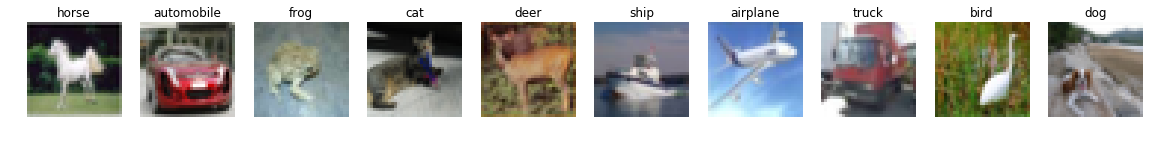

In [9]:
plt.figure(figsize=(20,4))
for i in range(10):
    t = i * 5000
    pic = data[t]
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 10, i+1)
    plt.axis("off")
    plt.title(str(labels[t]))
    plt.imshow(pic)
    
plt.show()  

The labels have to be in NumPy format as well. Furthermore, it needs to be one-hot encoded!

In [10]:
labels = np.array(labels) 
label_names = np.unique(labels)
print("The labels of the images: {}".format(label_names))

n_class = len(label_names)    # before one-hot encoding, let's check how many different labels we have

lbl = LabelBinarizer()
labels = lbl.fit_transform(labels)
pickle.dump(lbl, open("labels.pkl", "wb"))

print(labels.shape)
print(labels[:10])

The labels of the images: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
(50000, 10)
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]]


In [11]:
# converting back from one-hot encoding to the original label
lbl.inverse_transform(labels[0].reshape(1,10))

array(['horse'], dtype='<U10')

Moving on, we need to split our dataset for training, validation and testing. In this case, CIFAR-10 already has its own testing set, so we don't need to worry about that. What is a validation set?

The validation set is used to validate the performance of a model during training process, it is usually a small subset of the training set. But how much should we split? 60-40? 80-20?

In the "olden days", when the size of dataset is relatively small, say 500000 samples, it is reasonable to split with the ratio of 60-20-20 for training, validation and testing. But with the size of datasets growing into millions, having 20% for testing and validation may be too much. Say 5 million images, do we need 1 million of the images to validate? Using 1% (50000) of the images for validation or testing seems reasonable as well!

So it all depends on the task you are working on, you can split however you like, just make sure you have sufficient amount of samples in each set to carry out your task.

![set.PNG](slides/set.PNG)
_Image source: https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng_

With the testing set taken care of, we will split our training set with the ratio of 80-20 for training and testing.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=9)

We built the model earlier, let's load and visualize it

In [13]:
model = ConvNet.build(size, size, n_channels, n_class)

# you load the weights you trained previously and continue from that point
#model.load_weights("save/weights.h5")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [14]:
# compile the model!
# using Adam optimizer with the learning rate defined above
# the categorical crossentropy function will be used

opt = Adam(lr=LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

The dataset we are working on is limited (<5000 images per class after splitting), we can artificially enlarge the training set through data augmentation

In [15]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         fill_mode="nearest")

aug_set = aug.flow(X_train, y_train, batch_size=BS)

example_img = aug_set[5][0]
print("Total batches: {}".format(len(aug_set)))
print("Size of each batch: {}".format(example_img.shape))

Total batches: 176
Size of each batch: (256, 32, 32, 3)


Finally, let's train our CNN to classify the images!!

In [16]:
H = model.fit_generator(aug_set, validation_data=(X_val, y_val), epochs=EPOCHS, verbose=1)

model.save_weights("save/weights.h5")
#model.save("save/cifar10.h5")

Epoch 1/100
176/176 [==============================] - 12s 70ms/step - loss: 2.1920 - acc: 0.2965 - val_loss: 1.7328 - val_acc: 0.3964
Epoch 2/100
176/176 [==============================] - 11s 62ms/step - loss: 1.6370 - acc: 0.4197 - val_loss: 1.3363 - val_acc: 0.5208
Epoch 3/100
176/176 [==============================] - 11s 61ms/step - loss: 1.4522 - acc: 0.4845 - val_loss: 1.2632 - val_acc: 0.5526
Epoch 4/100
176/176 [==============================] - 11s 62ms/step - loss: 1.3418 - acc: 0.5239 - val_loss: 1.1540 - val_acc: 0.5856
Epoch 5/100
176/176 [==============================] - 11s 61ms/step - loss: 1.2568 - acc: 0.5508 - val_loss: 1.1286 - val_acc: 0.5992
Epoch 6/100
176/176 [==============================] - 11s 62ms/step - loss: 1.1916 - acc: 0.5755 - val_loss: 1.0957 - val_acc: 0.6148
Epoch 7/100
176/176 [==============================] - 11s 62ms/step - loss: 1.1256 - acc: 0.6019 - val_loss: 1.1998 - val_acc: 0.6078
Epoch 8/100
176/176 [==============================] - 

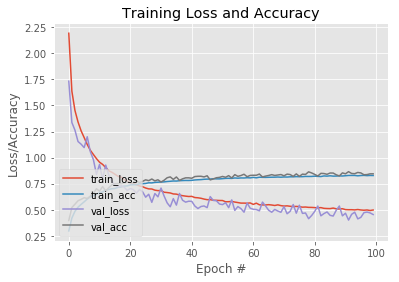

In [17]:
# plot the training and validation loss and accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Now that the CNN is trained, we can test this model on the unseen testing set!!

In [18]:
# delete variables to free up memory

var = [data, labels, X_train, y_train, X_val, y_val]
for v in var:
    del v

In [19]:
# import libraries!
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import itertools

In [20]:
# define variables that will be used
# load the model

files = glob.glob("cifar10/test/*/*")
lbl = pickle.load(open("labels.pkl", "rb"))

#model = load_model("save/cifar10.h5")
model = ConvNet.build(size, size, n_channels, n_class)   # load model
model.load_weights("save/weights.h5")                    # load weights

In [21]:
# read the testing images and labels into memory
# convert it into NumPy format

data = []
labels = []
for file in files:
    img = cv2.imread(file)
    label = file.split("/")[-2]
    
    data.append(img)
    labels.append(label)
    
data = np.array(data, dtype=np.float32) / 255.0
labels = np.array(labels)
labels = lbl.fit_transform(labels)              # we use back the LabelBinarizer that we used earlier

Then perform the prediction!

In [22]:
predictions = model.predict(data, verbose=1)

print("The first prediction is: {}".format(predictions[0]))

10000/10000 [==============================] - 1s 67us/step
The first prediction is: [6.8402992e-11 1.5045762e-11 9.0034602e-09 4.6025342e-10 1.0578921e-05
 3.7872780e-06 2.0346461e-12 9.9998558e-01 1.3763185e-13 1.7880100e-11]


In [23]:
# we take the biggest value in the labels and predictions, that will correspond to the class value

print("Labels: {}".format(labels.shape))
print("Predictions: {}".format(predictions.shape))

labels = np.argmax(labels, axis=-1)
predictions = np.argmax(predictions, axis=-1)

print("\nAfter argmax:")
print("Labels: {}".format(labels.shape))
print("Predictions: {}".format(predictions.shape))

Labels: (10000, 10)
Predictions: (10000, 10)

After argmax:
Labels: (10000,)
Predictions: (10000,)


We can then evaluate the model's performance in several ways, few of the common ways include accuracy, precision, recall and F1

Accuracy is just simply the percentage of correctly predicted testing samples. As for the other 3:
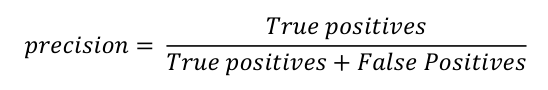
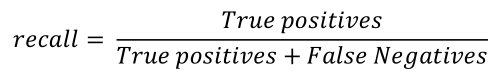
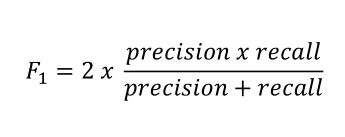

In [24]:
report = classification_report(labels, predictions, target_names=label_names)
accuracy = accuracy_score(labels, predictions)
print(report)
print("Accuracy = {:.2f}".format(accuracy))

             precision    recall  f1-score   support

   airplane       0.86      0.85      0.86      1000
 automobile       0.95      0.92      0.93      1000
       bird       0.88      0.73      0.80      1000
        cat       0.80      0.65      0.72      1000
       deer       0.76      0.88      0.82      1000
        dog       0.88      0.67      0.76      1000
       frog       0.74      0.95      0.83      1000
      horse       0.83      0.92      0.87      1000
       ship       0.92      0.87      0.90      1000
      truck       0.83      0.95      0.89      1000

avg / total       0.85      0.84      0.84     10000

Accuracy = 0.84


Not bad for a model with less than 300k parameters! We can evaluate further by looking at the confusion matrix

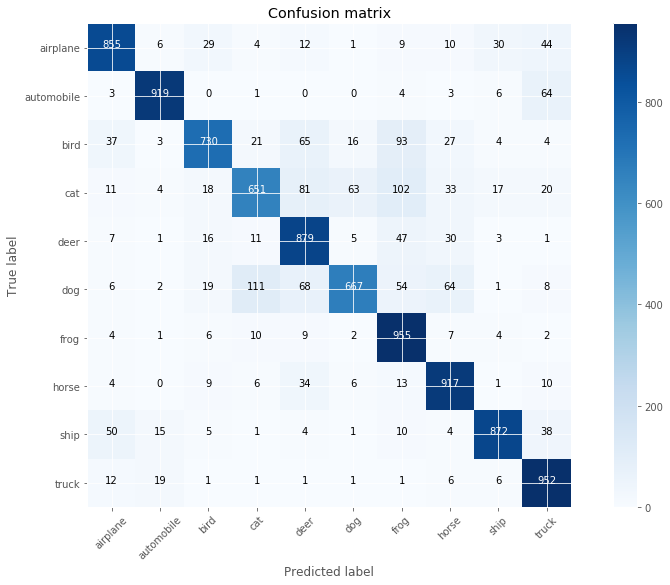

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()    
    
cm = confusion_matrix(labels, predictions)
plot_confusion_matrix(cm, label_names)

## The end, hope you enjoy =)

References:
 1. Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
 2. https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
 3. https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
 4. https://www.slideshare.net/TessFerrandez/notes-from-coursera-deep-learning-courses-by-andrew-ng
 5. https://github.com/ageron/handson-ml
 6. https://github.com/BIGBALLON/cifar-10-cnn
 7. https://keras.io
 8. https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html
 9. https://towardsdatascience.com/deep-learning-concepts-part-1-ea0b14b234c8

Further reading/learning:
 1. https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
 2. https://www.deeplearningbook.org
 3. https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
 4. https://towardsdatascience.com/image-augmentation-14a0aafd0498
 5. http://www.fast.ai
 6. https://www.deeplearning.ai
 7. https://www.coursera.org/learn/machine-learning

# Prepared by:
## Lim Yu-Quan
## Bachelor of Engineering (Honours) Mechatronic, Tunku Abdul Rahman University College

![me.PNG](slides/me.PNG)